In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import os
import torch.nn.functional as F
import seaborn as sns
import numpy as np  # Import NumPy as np
from torchvision.transforms import ToPILImage
from scipy.stats import gaussian_kde


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [57]:
custom_data_path = '/kaggle/input/brain-tumor-mri-dataset'
trainset = ImageFolder(root=os.path.join(custom_data_path, 'Training'), transform=transforms.ToTensor())

In [59]:
print(len(trainset))


5712


In [60]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False) #CHANGED: No need to load such big batch_size. With bigger datasets it may play a bad joke
data = next(iter(trainloader))[0]
mean = data.mean(axis=(0, 2, 3))
std = data.std(axis=(0, 2, 3))

In [61]:
print(mean,std)

tensor([0.1360, 0.1360, 0.1360]) tensor([0.1575, 0.1575, 0.1575])


In [63]:
normalize = transforms.Normalize(mean=mean, std=std)


In [64]:
# Define data augmentation and normalization transforms
reso = 224
#CHANGED: We can safely transform to 512x512. Even bigger, if training goes good
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((reso, reso),antialias=True),
    transforms.ToTensor(),
   normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((reso, reso),antialias=True),
    normalize
])

In [65]:
batch_size = 32
# Use ImageFolder to create a dataset
#labels are given as 0,1,2
#first folder has label 0 and so on
trainset = ImageFolder(root=os.path.join(custom_data_path, 'Training'), transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = ImageFolder(root=os.path.join(custom_data_path, 'Testing'), transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [66]:
print(len(trainset) + len(testset))

7023


In [67]:
len(testset)

1311

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [69]:
resnet50 = models.resnet50(pretrained=False ,num_classes = 4)  # You can choose a different ResNet variant


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [70]:
checkpoint_path = '/kaggle/input/resnet50-original/resnet50_full.pth'
#checkpoint_path = '/kaggle/input/improved-pth/segment_res50x_40_IMPROVED__epoch_TEMP.pth'
#checkpoint_path = '/kaggle/input/improved-pth/segment_res50x_40_IMPROVED__epoch_TEMP.pth'


checkpoint = torch.load(checkpoint_path)
#print(checkpoint.)
# Retrieve the components from the checkpoint
#epoch = checkpoint['epoch']
#lr = checkpoint['lr']
#model_state_dict = checkpoint['model_state_dict']
#optimizer_state_dict = checkpoint['optimizer_state_dict']
#loss = checkpoint['loss']

In [71]:
resnet50.load_state_dict(checkpoint)
#resnet50.load_state_dict(model_state_dict)

resnet50.eval()
resnet50.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [72]:
# Set the model to evaluation mode

resnet50.eval()

correct = 0
total = 0

# Disable gradient calculation during inference
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)  # Move data to the appropriate device (e.g., CPU or GPU)
        labels = labels.to(device)

        # Forward pass
        outputs = resnet50(images)
        
        # Get predicted labels
        _, predicted = torch.max(outputs, 1)
        
        # Count total and correctly predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = (correct / total) * 100.0

print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')

Accuracy of the model on the test dataset: 97.71%


In [73]:
chest_path = '/kaggle/input/brain-tumor'
# Load the dataset with the first 1000 images
first_1000_testset = ImageFolder(root=os.path.join(chest_path, 'Brain Tumor'), transform=transform_test)
first_1000_testset.samples = first_1000_testset.samples[:1000]
first_1000_testset.targets = first_1000_testset.targets[:1000]

testloader_chest = torch.utils.data.DataLoader(first_1000_testset, batch_size=batch_size, shuffle=False, num_workers=2)
#testset_chest = ImageFolder(root=os.path.join(chest_path, 'Brain Tumor'), transform=transform_test)

#testloader_chest = torch.utils.data.DataLoader(testset_chest, batch_size=batch_size, shuffle=False, num_workers=2)

In [74]:
print(len(first_1000_testset))

1000


In [75]:
def get_softmax_scores(model, dataloader):
    scores = []
    outputs_raw = []
    device = next(model.parameters()).device  # Get the device of the model's parameters

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)  # Move inputs to the same device as the model
            outputs = model(inputs)
            softmax_scores = F.softmax(outputs, dim=1)
            scores.append(softmax_scores)
            outputs_raw.append(outputs)

    scores = torch.cat(scores)
    outputs_raw = torch.cat(outputs_raw)
    return scores, outputs_raw

In [76]:
brain_softmax_scores,scores_brain = get_softmax_scores(resnet50, testloader)  
print(len(brain_softmax_scores))
print(brain_softmax_scores)

1311
tensor([[1.0000e+00, 4.0899e-08, 1.9218e-06, 3.4367e-07],
        [9.9989e-01, 1.4569e-05, 6.5935e-05, 2.6948e-05],
        [9.9973e-01, 8.9086e-05, 1.8123e-04, 3.7669e-06],
        ...,
        [2.0279e-07, 6.3401e-05, 6.2098e-06, 9.9993e-01],
        [8.4023e-01, 1.1129e-03, 1.5265e-05, 1.5864e-01],
        [1.1093e-04, 2.2944e-05, 1.0721e-05, 9.9986e-01]], device='cuda:0')


In [77]:
chest_softmax_scores,scores_chest = get_softmax_scores(resnet50, testloader_chest)
print(len(chest_softmax_scores))
print(chest_softmax_scores)


1000
tensor([[8.4902e-01, 9.7083e-02, 5.3614e-02, 2.8370e-04],
        [4.0869e-09, 1.0000e+00, 1.1998e-06, 2.8045e-08],
        [7.6658e-03, 9.4498e-01, 4.7092e-02, 2.5717e-04],
        ...,
        [1.6429e-04, 8.1285e-01, 1.8694e-01, 5.3027e-05],
        [2.3903e-04, 1.4380e-01, 8.5593e-01, 3.6391e-05],
        [4.3989e-03, 3.8621e-02, 9.5696e-01, 2.1704e-05]], device='cuda:0')


In [78]:
def max_softmax_score(softmax_scores):
    
    max_scores, _ = torch.max(softmax_scores, dim=1)
    return max_scores
    

In [79]:
max_brain = max_softmax_score(brain_softmax_scores)
max_chest = max_softmax_score(chest_softmax_scores)
#print(max_chest)

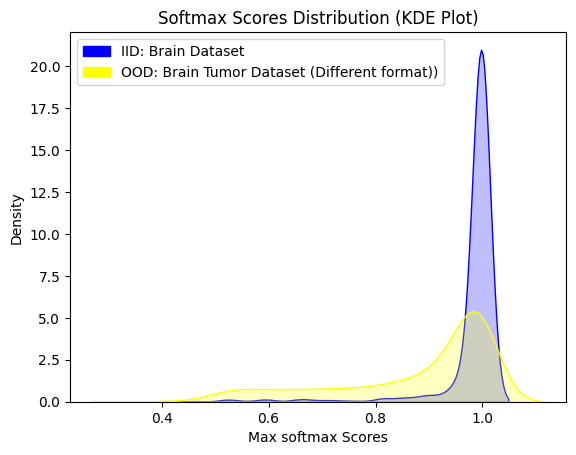

In [97]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


# Transfer tensors from GPU to CPU
max_brain_cpu = max_brain.cpu().numpy()
max_chest_cpu = max_chest.cpu().numpy()
# Create a KDE plot
sns.kdeplot(max_brain_cpu, fill=True, color = "blue")
sns.kdeplot(max_chest_cpu, fill=True, color = "yellow")

# Calculate the intersection point
kde_brain = gaussian_kde(max_brain_cpu)
kde_chest = gaussian_kde(max_chest_cpu)
x = np.linspace(min(max_brain_cpu.min(), max_chest_cpu.min()), max(max_brain_cpu.max(), max_chest_cpu.max()), 1000)
thr_softmax = x[np.argmin(np.abs(kde_brain(x) - kde_chest(x)))]

# Add shaded region and text label
#plt.axhspan(ymin=19, ymax=20, xmin=0.22, xmax=0.25, color="blue")
#plt.text(0.2, 4.2, "IID: Brain", fontsize=12, color="black")

#plt.axhspan(ymin=3.9, ymax=3.95, xmin=0.04, xmax=0.07, color="yellow")
#plt.text(0.2, 3.9, "OOD: Chest", fontsize=12, color="Black")

# Create a custom legend element to represent "blue" as a blue bar
custom_legend_id = [Patch(color='blue', label='IID: Brain Dataset ')]
custom_legend_ood = [Patch(color='yellow', label='OOD: Brain Tumor Dataset (Different format))')]

combined_legend = custom_legend_id + custom_legend_ood


# Customize the plot
#plt.xlabel("Max softmax Score")
plt.xlabel("Max softmax Scores")

plt.ylabel("Density")
plt.title("Softmax Scores Distribution (KDE Plot)")

plt.legend(handles=combined_legend, loc='upper left')


# Add shaded region and text label near the x-label
#plt.axhspan(ymin=19, ymax=20, xmin=0.04, xmax=0.07, color="blue")
#plt.text(0.06, 19.5, "IID: Brain", fontsize=12, color="black")
plt.savefig('kde_plot_brain_diff_format_set.png')

# Display the plot or save it to a file
plt.show()

In [98]:
import numpy as np
from scipy.optimize import brentq
from scipy.stats import gaussian_kde
# Define a function to find the intersection points
def find_intersection(kde1, kde2, x_min, x_max, num_points=1000):
    x_values = np.linspace(x_min, x_max, num_points)
    y1 = kde1(x_values)
    y2 = kde2(x_values)
    
    intersection_points = []
    
    for i in range(1, num_points):
        if y1[i] > y2[i] and y1[i - 1] < y2[i - 1]:
            intersection_x = brentq(lambda x: kde1(x) - kde2(x), x_values[i - 1], x_values[i])
            intersection_points.append(intersection_x)
    
    return intersection_points

# Define the range over which you want to find intersections
x_min = min(np.min(max_brain_cpu), np.min(max_chest_cpu))
x_max = max(np.max(max_brain_cpu), np.max(max_chest_cpu))

# Find intersection points
intersection_points = find_intersection(kde_brain, kde_chest, x_min, x_max)

# Print the intersection points
print("Intersection Points:", intersection_points)







Intersection Points: [0.9670870935990015]


In [99]:
max_brain_cpu_softmax = max_brain.cpu().numpy()
max_chest_cpu_softmax = max_chest.cpu().numpy()
#thr_softmax = thresholdize(max_brain_cpu_softmax,max_chest_cpu_softmax)
print(thr_softmax)
#print(intersection)

0.38499993085861206


In [100]:
threshold = thr_softmax # Adjust as needed
threshold = 0.9670870935990015
def classify_samples(softmax_scores, threshold):
    max_scores, _ = torch.max(softmax_scores, dim=1)
    ood_samples = max_scores < threshold
    return ood_samples

In [101]:
brain_ood_samples = classify_samples(brain_softmax_scores, threshold)
chest_ood_samples = classify_samples(chest_softmax_scores, threshold)

In [102]:
brain_ood_samples_num = brain_ood_samples.cpu().numpy()
chest_ood_samples_num = chest_ood_samples.cpu().numpy()
print(np.sum(brain_ood_samples_num).item())
print(np.sum(chest_ood_samples_num).item())

135
559


In [104]:
ID_len = len(testset)
#print(ID_len)
OOD_len = len(testset_chest)

#True Positives (TP): The number of ID data points correctly classified as ID.
TP = ID_len- np.sum(brain_ood_samples_num).item()
#print(TP)
#False Positives (FP): The number of OOD data points incorrectly classified as ID.
FP = OOD_len - np.sum(chest_ood_samples_num).item()
#True Negatives (TN): The number of OOD data points correctly classified as OOD.
TN = np.sum(chest_ood_samples_num).item()
#False Negatives (FN): The number of ID data points incorrectly classified as OOD.
FN = np.sum(brain_ood_samples_num).item()
#print(FN)
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
Accuracy = (TP + TN) / (TP + FP + TN + FN)
Precision = TP / (TP + FP)
F1_Score = 2 * (Precision * TPR) / (Precision + TPR)
print("Statistics for Softmax OOD on Brain Tumor (Different Format) Dataset ")
print(f"True Positive Rate  {TPR:.3g}")
print(f"False Positive Rate  {FPR:.3g}")
print(f"Accuracy  {Accuracy:.3g}")
print(f"Precision  {Precision:.3g}")
print(f"F1_Score  {F1_Score:.3g}")

Statistics for Softmax OOD on Brain Tumor (Different Format) Dataset 
True Positive Rate  0.897
False Positive Rate  0.851
Accuracy  0.342
Precision  0.269
F1_Score  0.413


In [105]:
print(f"Number of ID samples classified as OOD usig softmax {torch.sum(brain_ood_samples).item():.3g}")
print(f"Number of OOD samples classified as OOD usig softmax {torch.sum(chest_ood_samples).item():.3g}")

Number of ID samples classified as OOD usig softmax 135
Number of OOD samples classified as OOD usig softmax 559


In [106]:
d=2
def energy(out, axis = 1, numpy = True, T = 1, correction = False , ty='not_num'): #actually takes negative energy
    print("Called")

    if ty == 'not_num':
        #print("correct")
        #out = out.detach().numpy()

        #print(out)
        #denominator of softmax np.sum(np.exp(out/T)
        scores = T*np.log(np.sum(np.exp(out/T), axis = axis))
    if correction:
        print("here")
        scores -= T*np.log(d)

    return scores

In [107]:
scores_brain_cpu = scores_brain.cpu().numpy()
scores_chest_cpu = scores_chest.cpu().numpy()
# Energy Scores
ID_energy_score = energy(scores_brain_cpu)
OOD_energy_score = energy(scores_chest_cpu)

Called
Called


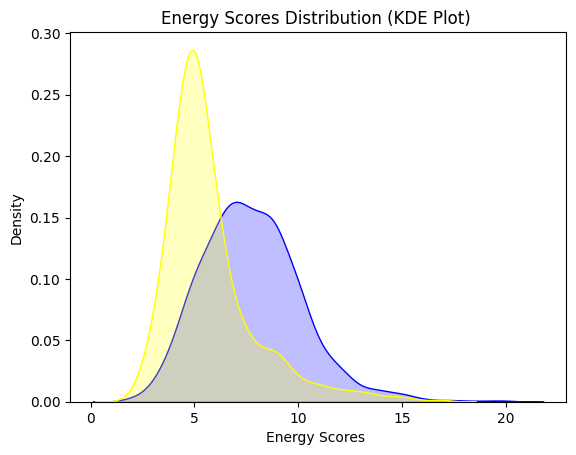

In [108]:
# Create a KDE plot
sns.kdeplot(ID_energy_score, fill=True, color = "blue")
sns.kdeplot(OOD_energy_score, fill=True, color = "yellow")

# Calculate the intersection point
kde_brain_energy = gaussian_kde(ID_energy_score)
kde_chest_chest = gaussian_kde(OOD_energy_score)
x = np.linspace(min(ID_energy_score.min(), OOD_energy_score.min()), max(ID_energy_score.max(), OOD_energy_score.max()), 1000)
thr_energy = x[np.argmin(np.abs(kde_brain_energy(x) - kde_chest_chest(x)))]
#plt.axvline(thr_energy, color="red", linestyle="--", label=f"Intersection ({thr_energy:.2f})")

# Customize the plot
plt.xlabel("Energy Scores ")
plt.ylabel("Density")
plt.title("Energy Scores Distribution (KDE Plot) ")
plt.savefig('kde_plot_energy_brain_diff_format_set.png')

# Display the plot or save it to a file
plt.show()

In [109]:
def find_intersection(kde1, kde2, x_min, x_max, num_points=1000):
    x_values = np.linspace(x_min, x_max, num_points)
    y1 = kde1(x_values)
    y2 = kde2(x_values)
    
    intersection_points = []
    
    for i in range(1, num_points):
        if y1[i] > y2[i] and y1[i - 1] < y2[i - 1]:
            intersection_x = brentq(lambda x: kde1(x) - kde2(x), x_values[i - 1], x_values[i])
            intersection_points.append(intersection_x)
    
    return intersection_points

# Define the range over which you want to find intersections
x_min = 0
x_max = 20

# Find intersection points
intersection_points = find_intersection(kde_brain_energy, kde_chest_chest, x_min, x_max)

# Print the intersection points
print("Intersection Points:", intersection_points)

Intersection Points: [6.256716287920738, 16.968778546593615]


In [110]:
#thr = thresholdize(ID_energy_score,OOD_energy_score)
#thr =12.5

thr_energy = 6.256716287920738
print(thr_energy)

6.256716287920738


In [111]:
ID_OOD = ID_energy_score < thr_energy
print(ID_OOD)
OOD = OOD_energy_score < thr_energy
#print(np.sum(ID_OOD).item())
#print(np.sum(OOD).item())
print(f"Number of ID sample {len(ID_energy_score)}")
print(f"Number of OOD sample {len(OOD_energy_score)}")
result = np.sum(ID_OOD).item()
formatted_result = f'{result:,.0f}'
#print(f"Number of ID samples classified as OOD usig Energy  {np.sum(ID_OOD).item():.3g}")
print(f"Number of ID samples classified as OOD using Energy: {formatted_result}")
res2 = np.sum(OOD).item()
format2 = f'{res2:,.0f}'
print(f"Number of OOD samples classified as OOD usig Energy {format2}")


[False False False ... False  True False]
Number of ID sample 1311
Number of OOD sample 1000
Number of ID samples classified as OOD using Energy: 365
Number of OOD samples classified as OOD usig Energy 738


In [112]:
#ID_len = len(ID_energy_score)
#OOD_len = len(OOD_energy_score)
#True Positives (TP): The number of ID data points correctly classified as ID.
TP = ID_len- np.sum(ID_OOD).item()
#False Positives (FP): The number of OOD data points incorrectly classified as ID.
FP = OOD_len - np.sum(OOD).item()
#True Negatives (TN): The number of OOD data points correctly classified as OOD.
TN = np.sum(OOD).item()
#False Negatives (FN): The number of ID data points incorrectly classified as OOD.
FN = np.sum(ID_OOD).item()

In [113]:
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
Accuracy = (TP + TN) / (TP + FP + TN + FN)
Precision = TP / (TP + FP)
F1_Score = 2 * (Precision * TPR) / (Precision + TPR)

In [114]:
print("Statistics for Energy OOD ")
print(f"True Positive Rate  {TPR:.3g}")
print(f"False Positive Rate  {FPR:.3g}")
print(f"Accuracy  {Accuracy:.3g}")
print(f"Precision  {Precision:.3g}")
print(f"F1_Score  {F1_Score:.3g}")


Statistics for Energy OOD 
True Positive Rate  0.722
False Positive Rate  0.804
Accuracy  0.332
Precision  0.238
F1_Score  0.358
